In [6]:
import os
import sys
from matplotlib import rc
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('display.max_rows', 10)

In [17]:
def load_data(name):
    df = pd.read_csv(name, index_col=False)
    return df

def drop_col(fname):
    df_new = pd.DataFrame()
    dirr = os.path.join(os.getcwd(), "data", "csv_files", fname)
    cs_files = [os.path.join(dirr, f) for f in os.listdir(dirr)]
    pop_files = [os.path.join(dirr, f) for f in os.listdir(dirr)]
    if fname == "cs": fname = cs_files
    if fname == "pop": fname = pop_files
    c = 0
    for i in fname:
        df = load_data(i)
        to_ren = {"Allcancers":"All cancers", "Non-Hodgkinlymphoma":"Non-Hodgkin lymphoma",
                 "Lip,oralcavity":"Lip, oral cavity", "Brain,centralnervoussystem":"Brain, central nervous system",
                 "Melanomaofskin":"Melanoma of skin", "Multiplemyeloma":"Multiple myeloma",
                 "Hodgkinlymphoma":"Hodgkin lymphoma", "Salivaryglands":"Salivary glands", "Kaposisarcoma":"Kaposi sarcoma",
                 "Cervixuteri":"Cervix uteri", "Corpusuteri":"Corpus uteri"}
        df.drop(["Cum. risk**", "Uncertainty interval", "ICD"], axis=1, inplace=True)
        if "inc_f" in i: df.rename({"Number":"num_inc_f", "Crude Rate*":"cr_r_inc_f", "ASR (World)*":"asr_inc_f"}, axis=1, inplace=True)
        if "inc_m" in i: df.rename({"Number":"num_inc_m", "Crude Rate*":"cr_r_inc_m", "ASR (World)*":"asr_inc_m"}, axis=1, inplace=True)
        if "mort_f" in i: df.rename({"Number":"num_mort_f", "Crude Rate*":"cr_r_mort_f", "ASR (World)*":"asr_mort_f"}, axis=1, inplace=True)
        if "mort_m" in i: df.rename({"Number":"num_mort_m", "Crude Rate*":"cr_r_mort_m", "ASR (World)*":"asr_mort_m"}, axis=1, inplace=True)

        if c == 0: df_new = df
        if c != 0: df_new = df_new.merge(df, how="outer", left_on="Cancer", right_on="Cancer")
            
        c+=1
    df_new["Cancer"].replace(to_ren, inplace=True)
    df_new.fillna(0, inplace=True)
            
    return df_new

def plot_pie(dtype, top_n):
    
    if dtype == "m": dtype = "num_mort"
    if dtype == "i": dtype = "num_inc"
    df = drop_col("cs")
    df["num_mort"] = df["num_mort_m"] + df["num_mort_f"]
    df["num_inc"] = df["num_inc_f"] + df["num_inc_m"]
    df.sort_values(dtype, inplace=True, ascending=False)

    dmtype = dtype + "_m"
    dftype = dtype + "_f"
    d = {"Cancer":"Other", dtype:[df[dtype][0] - np.sum(df[dtype][1:top_n+1])], 
        dmtype:[df[dmtype][0] - np.sum(df[dmtype][1:top_n+1])],
        dftype:[df[dftype][0] - np.sum(df[dftype][1:top_n+1])]}
    df_new = pd.DataFrame(d)
    dff = pd.concat([df, df_new], sort=False)
    dff.reset_index(drop=True, inplace=True)
    last_row = dff.shape[0]
    a,b = dff.iloc[last_row-1], dff.iloc[top_n+1]
    temp = dff.iloc[last_row-1].copy()
    dff.iloc[last_row-1] = b
    dff.iloc[top_n+1] = temp
    
    to_ren = {"Lung":"Легкие", "Colorectum":"Толстый кишечник", "Stomach":"Желудок",
             "Liver":"Печень", "Breast":"Молочная железа", "Oesophagus":"Пищевод",
             "Pancreas":"Поджелудочная\nжелеза", "Prostate":"Простата", "Other":"Другие",
             "Cervix uteri":"Шейка матки", "Leukaemia":"Лейкемия", "Thyroid":"Щитовидная железа",
             "Bladder":"Мочевой пузырь"}

    counter = top_n+1
    fig1, ax1 = plt.subplots()
    cmap = sns.color_palette("Set3", counter)
    col_dict = {list(to_ren.values())[i]:cmap[i] for i in range(counter)}
    col_dict["Другие"] = "lightgray"
    
    expl_val = dff.loc[dff['Cancer']=='Liver'].index[0]
    explode = [0.2 if i == expl_val-1 else 0.0 for i in range(counter)]
    explode_g = [0.2 if i == expl_val*2-2 else 0.2 if i == expl_val*2-1 else 0.0 for i in range(2*(counter))]
    
    col_g, gender = [], []
    for i in range(counter): 
        gender.extend([dff[dmtype][i+1], dff[dftype][i+1]])
        col_g.extend(["#c2c2f0", "#ffb3e6"])
        
    dff["Cancer"].replace(to_ren, inplace=True)

    col_cm = [col_dict[organ] for organ in dff["Cancer"][1:counter+1]]
    
    fs=16
    
    plt.rc('text', usetex=True)
    plt.rc('font', **{'family': 'serif', "size":fs-1})
    plt.rc('text.latex', unicode=True)        
    plt.rcParams['text.latex.preamble'] = [r'\usepackage[english,russian]{babel}', \
                                           r'\usepackage[T2A]{fontenc}']
    
    edge = {"edgecolor":"k",'linewidth': .5}
    plt.pie(dff[dtype][1:counter+1], labels=dff["Cancer"][1:counter+1], 
            startangle=180, autopct='%1.1f%%', colors=col_cm,
            explode=explode, pctdistance=0.73, labeldistance=1.1, radius=3,
           wedgeprops= edge, counterclock = False
           )
    
    plt.pie(gender, startangle=180, colors=col_g, explode=explode_g,
            radius=1.5, wedgeprops=edge, counterclock = False)
    plt.axis("equal")
    
    centre_circle = plt.Circle((0,0), 1.2, color="black", fc='white', linewidth=0.5, edgecolor='k')
    fig = plt.gcf()
    fig.gca().add_artist(centre_circle)
    
    name = os.path.join(os.getcwd(), "pics", dtype)
    
    plt.savefig(name, dpi=300)
    
    return None

/home/emir/miniconda3/envs/lab/lib/python3.7/site-packages/matplotlib/__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcparam", addendum=addendum)
/home/emir/miniconda3/envs/lab/lib/python3.7/site-packages/matplotlib/patches.py:75: UserWarning: Setting the 'color' property will overridethe edgecolor or facecolor properties.
  warnings.warn("Setting the 'color' property will override"


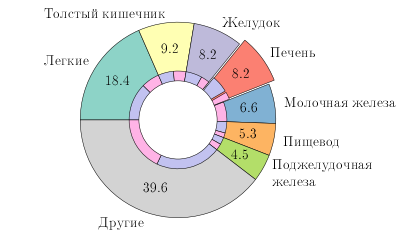

In [19]:
plot_pie("m",7)